# Visualiser une image

In [33]:
import nibabel as nib
import matplotlib.pyplot as plt

def afficher_image_3D(path,deepth=0):
    img = nib.load(path)
    data = img.get_fdata()
    print(f"Dimensions: {data.shape}")

    # Afficher une coupe axiale au milieu
    plt.imshow(data[:, :, deepth], cmap='gray')
    plt.title("Coupe axiale (slice at depth {})".format(deepth))
    plt.axis('off')
    plt.show()
    return data

Dimensions: (512, 512, 91)


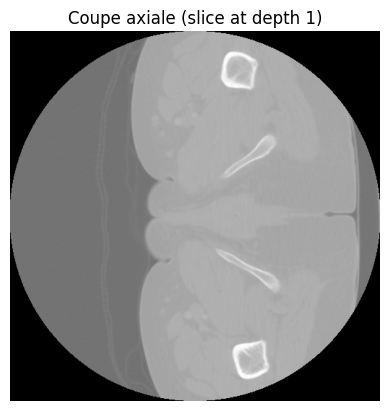

In [34]:
data = afficher_image_3D("./DatasetChallenge/images/330707.nii.gz", 1)

# Supperposer une image et son label 

In [35]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

def afficher_image_et_masque(number, slice_index=None):
    path = "./DatasetChallenge/"
    image_path = path + "images/" + str(number) + ".nii.gz"
    masque_path = path + "labels/" + str(number) + ".nii.gz"
    image = nib.load(image_path).get_fdata()
    masque = nib.load(masque_path).get_fdata()

    assert image.shape == masque.shape, "Image et masque doivent avoir les mêmes dimensions"

    if slice_index is None:
        slice_index = image.shape[2] // 2  # Coupe axiale au milieu

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image[:, :, slice_index], cmap='gray')
    plt.title("Image (Coupe axiale)")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(masque[:, :, slice_index], cmap='gray')
    plt.title("Masque de tumeur")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(image[:, :, slice_index], cmap='gray')
    plt.imshow(masque[:, :, slice_index], alpha=0.4, cmap='Reds')
    plt.title("Superposition")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


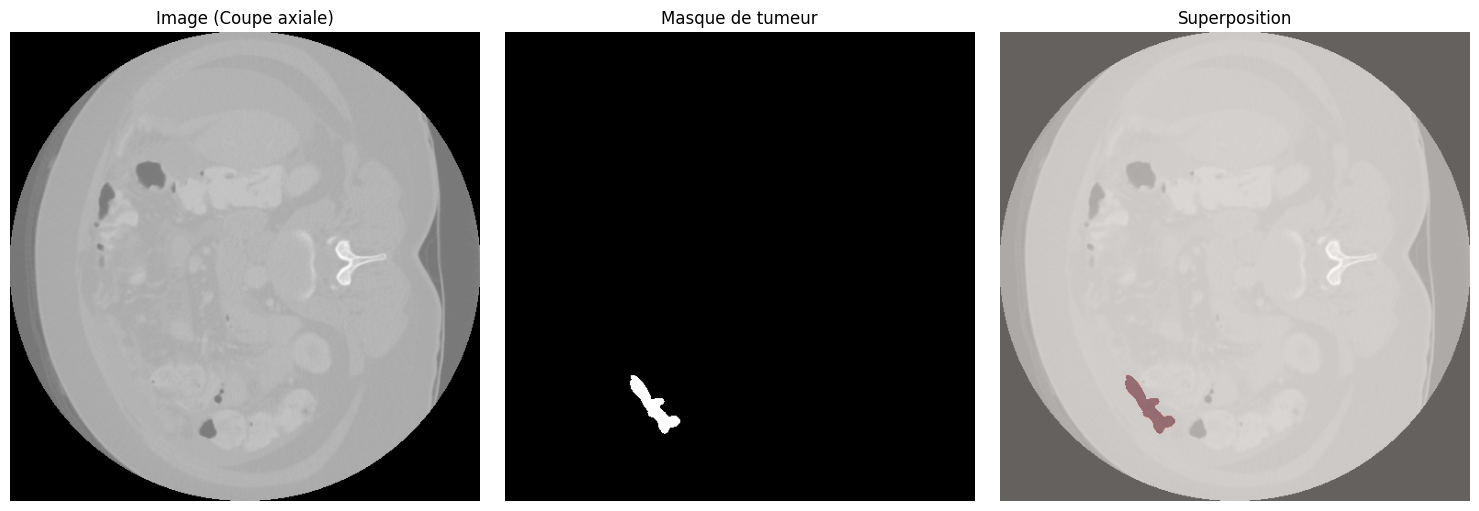

In [36]:
afficher_image_et_masque(330707, 52)

# Création Pytorch Dataset

In [37]:
import os
import torch
import nibabel as nib
import numpy as np
from torch.utils.data import Dataset
import torchvision.transforms as T

class OvarianDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None, slice_axis=2):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.filenames = sorted(os.listdir(images_dir))
        self.transform = transform
        self.slice_axis = slice_axis  # 0, 1 ou 2

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.filenames[idx])
        label_path = os.path.join(self.labels_dir, self.filenames[idx])

        image = nib.load(img_path).get_fdata()
        label = nib.load(label_path).get_fdata()

        # On prend une coupe au milieu pour simplifier (2D)
        middle = image.shape[self.slice_axis] // 2
        if self.slice_axis == 0:
            image = image[middle, :, :]
            label = label[middle, :, :]
        elif self.slice_axis == 1:
            image = image[:, middle, :]
            label = label[:, middle, :]
        else:
            image = image[:, :, middle]
            label = label[:, :, middle]

        # Normalisation simple
        image = (image - np.min(image)) / (np.max(image) - np.min(image))

        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # [1, H, W]
        label = torch.tensor(label, dtype=torch.float32).unsqueeze(0)  # [1, H, W]

        return image, label


In [38]:
from torch.utils.data import DataLoader
path_images = "./DatasetChallenge/images"
path_labels = "./DatasetChallenge/labels"

dataset = OvarianDataset(path_images, path_labels)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Tester un batch
for x, y in dataloader:
    print("Image:", x.shape)  # [B, 1, H, W]
    print("Label:", y.shape)  # [B, 1, H, W]
    break


Image: torch.Size([4, 1, 512, 512])
Label: torch.Size([4, 1, 512, 512])


# Modèle : Mini U-Net

In [39]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    """Deux convolutions + ReLU + BatchNorm"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.down1 = DoubleConv(1, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(32, 64)
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(64, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.upconv1 = DoubleConv(128, 64)
        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.upconv2 = DoubleConv(64, 32)

        self.final_conv = nn.Conv2d(32, 1, kernel_size=1)  # binaire

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(self.pool1(d1))
        b = self.bottleneck(self.pool2(d2))

        u1 = self.up1(b)
        u1 = self.upconv1(torch.cat([u1, d2], dim=1))
        u2 = self.up2(u1)
        u2 = self.upconv2(torch.cat([u2, d1], dim=1))

        out = self.final_conv(u2)
        return torch.sigmoid(out)  # probas entre 0 et 1


## fonction de perte : Dice loss

In [40]:
def dice_loss(pred, target, smooth=1e-6):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)


## fonction d'entrainement 

In [41]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

def train(model, dataloader, optimizer, device):
    model.train()
    epoch_loss = 0

    for batch in tqdm(dataloader):
        images, masks = batch  # car DataLoader retourne (image, label)
        images = images.to(device)
        masks = masks.to(device)


        preds = model(images)
        loss = dice_loss(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(dataloader)


## boucle d'entrainement 

In [ ]:
from torch.utils.data import DataLoader

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Dataloader
train_loader = DataLoader(dataset, batch_size=2, shuffle=True)

# Entraînement rapide
for epoch in range(3):  # juste 3 époques pour tester
    loss = train(model, train_loader, optimizer, device)
    print(f"Époque {epoch+1}, Loss: {loss:.4f}")


  3%|▎         | 3/100 [00:08<04:41,  2.90s/it]